In [1]:
import os
import time
import torch
from functools import reduce
# 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import sklearn

# Torch
import torch
from torch.distributions import Bernoulli
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

# Torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

In [2]:
batch_size = int(512)
# epochs = 5 # defined at training loop
latent_dim = 8
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NNprint_ = False
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)

In [3]:
# transforms arrays into tensors, can be extended
transformations = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Lambda(lambda p: Bernoulli(probs=p).sample())]
                          )

# define the train and test sets
dset_train = MNIST(root='data', train=True,  transform=transformations, download=True)
dset_test  = MNIST(root='data', train=False, transform=transformations)

def stratified_sampler(labels,classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
def get_target_indexes(dset, classes, n_examples):
  """Get indexes for n_examples of class in classes from dataset

  The returned indexes may be used for subsetting a dataset, e.g.
  if we just want classes 0, 1 and 2 and 10 examples of each.
  """
  idxs = []
  ts = []
  n_samples = n_examples * len(classes)

  for j, x in enumerate(dset.targets):
    if (ts.count(x.numpy()) < n_examples) and (x.numpy() in classes):
      ts.append(x.numpy())
      idxs.append(j)

    if len(idxs) == n_samples:
      break

  return idxs

In [5]:
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets,classes))
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.targets,classes))

# subset training data
idx_train_subset = get_target_indexes(dset_train, classes, 100)
dset_train_subset = torch.utils.data.Subset(dset_train, idx_train_subset)

dset_train_subset_loader = torch.utils.data.DataLoader(
  dset_train_subset,
  batch_size=batch_size)

# subset test data
idx_test_subset = get_target_indexes(dset_test, classes, 100)
dset_test_subset = torch.utils.data.Subset(dset_test, idx_test_subset)

dset_test_subset_loader = torch.utils.data.DataLoader(
  dset_test_subset,
  batch_size=batch_size)

In [6]:
# import os
# import time
# import torch
# import argparse
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from torchvision import transforms
# from torchvision.datasets import MNIST
# from torchvision.datasets import FashionMNIST
# from torch.utils.data import DataLoader
# from collections import defaultdict
# import torch.nn.functional as F
# import numpy as np
# from functools import reduce
# from torch.utils.data.sampler import SubsetRandomSampler

# torch.cuda.empty_cache()

In [7]:
# bs=32
# train = MNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=True)
# test= MNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=False)

In [8]:


# bs=32*8*2
# train = FashionMNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=True)
# test= FashionMNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=False)

In [9]:
# def stratified_sampler(labels,classes):
#     """Sampler that only picks datapoints corresponding to the specified classes"""
#     (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
#     indices = torch.from_numpy(indices)
#     return SubsetRandomSampler(indices)


In [10]:
# classes=[0,1,2,3,4,5]
# num_classes=len([0,1,2])
# train_loader = torch.utils.data.DataLoader(
#   train,
#   batch_size=bs,sampler=stratified_sampler(train.targets,classes))

# test_loader = torch.utils.data.DataLoader(
#   test,
#   batch_size=bs,sampler=stratified_sampler(test.targets,classes))

In [11]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [12]:
def plot_examples(model=None,sample=False,data=None):
    if data is None:
        if (model==None):
            batch_idx, (data, example_targets) = next(examples)
        else:
            if sample:
                data = model.sample()
            else:
                data = model(data.to(device),example_targets)[0]
        
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.tight_layout()
        if model:
            plt.imshow(data[i][0].cpu().data,  interpolation='none')
        else:
            plt.imshow(data[i][0], interpolation='none')
    #     plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

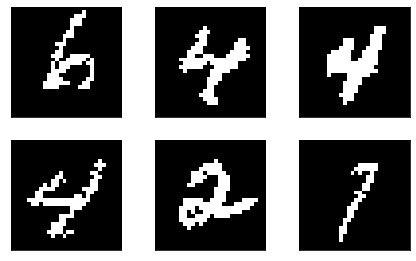

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#     plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
# fig

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [15]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [16]:
class UnFlatten(torch.nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [17]:
NNprint_=False
class NNprint(torch.nn.Module):
    def forward(self, input):
        if NNprint_==True:
            print(input.shape)
        return input

In [18]:

class VAE(torch.nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32,num_labels=0):
        super(VAE, self).__init__()
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.encoder = torch.nn.Sequential(
            NNprint(),
            torch.nn.Conv2d(image_channels, 32, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            Flatten(),
            
            
            NNprint(),
            
        )
        self.h_dim=h_dim
        self.num_labels=num_labels
        self.fc1 = torch.nn.Linear(h_dim, z_dim)
        self.fc2 = torch.nn.Linear(h_dim, z_dim)
        self.fc3 = torch.nn.Linear(z_dim+num_labels, h_dim)
        
        self.decoder = torch.nn.Sequential(
            NNprint(),
            UnFlatten(),
            NNprint(),
            torch.nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4,padding=0, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=1),
            torch.nn.Sigmoid(),
            NNprint(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu.to(device) + std.to(device) * esp.to(device)
        return z
    
    def bottleneck(self, h,labels):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        if self.num_labels>0:
            z=torch.cat((z,torch.nn.functional.one_hot(labels,self.num_labels).type(torch.float).to(device)),1)
        return z, mu, logvar

    def encode(self, x,labels):
        h = self.encoder(x)
#         h=torch.cat((h,labels.float().reshape(labels.size(0),1).to(device)),dim=1)
        z, mu, logvar = self.bottleneck(h,labels)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x,labels):
        z, mu, logvar = self.encode(x,labels)
#         print('z',z.shape)
        z = self.decode(z)
        return z, mu, logvar
    
    def sample(self, batch_size: int = 100,z_out=False):
        """Sample z~p(z) and return p(x|z) / reconstruction
        """
        # sample z ~ N(0,I)
        mu, logvar = torch.zeros((batch_size, self.z_dim)), torch.ones(
            batch_size, self.z_dim)
        z = self.reparameterize(mu, logvar)
        if z_out:
            return z
        # decode sampled z with condition
        else:
            x_recon = self.decode(z)
            return x_recon.detach()  # no gradient_fn

In [19]:
image_channels = example_data.size(1)
image_channels

1

In [20]:
model = VAE(image_channels=image_channels,h_dim=1024,z_dim=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [21]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.to(device), size_average=False,reduction='sum' )
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

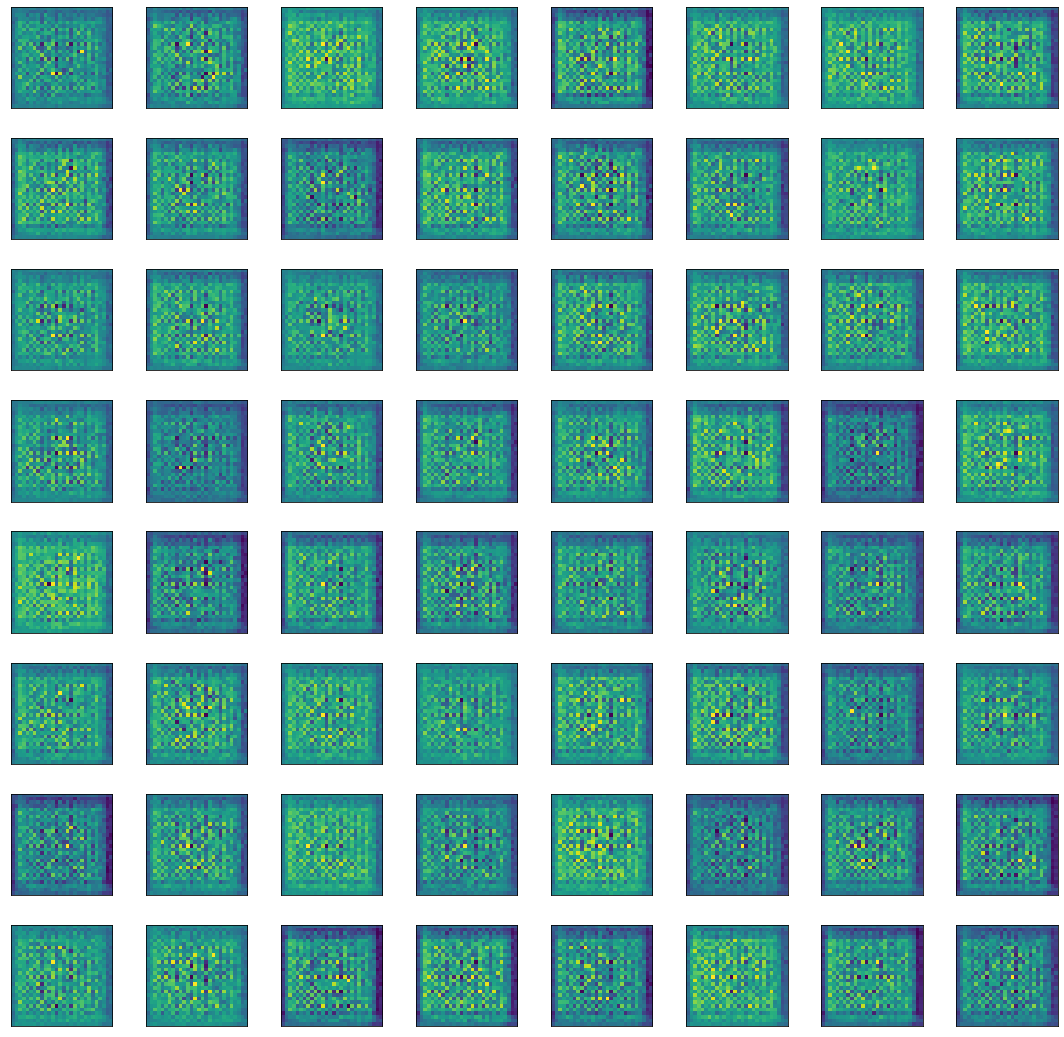

In [22]:
plot_examples(model=model, sample=True)

In [23]:
epochs=100

In [24]:
%%time
model.train
for epoch in range(epochs):
    for idx, (images, labels) in enumerate(train_loader):
#         print(idx)
        recon_images, mu, logvar = model(images.to(device),labels)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx%500==0:
            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                        epochs, loss.data.cpu().numpy().tolist()/batch_size, bce.data.cpu().numpy().tolist()/batch_size, kld.data.cpu().numpy().tolist()/batch_size)
            print(to_print)
torch.save(model.state_dict(), 'vae.torch')


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/100] Loss: 580.996 580.996 0.000
Epoch[2/100] Loss: 148.507 148.484 0.023
Epoch[3/100] Loss: 101.682 101.664 0.018
Epoch[4/100] Loss: 93.073 93.056 0.016
Epoch[5/100] Loss: 91.822 91.806 0.016
Epoch[6/100] Loss: 86.985 86.969 0.016
Epoch[7/100] Loss: 84.341 84.325 0.015
Epoch[8/100] Loss: 84.034 84.020 0.014
Epoch[9/100] Loss: 85.195 85.180 0.014
Epoch[10/100] Loss: 82.351 82.337 0.015
Epoch[11/100] Loss: 76.336 76.322 0.015
Epoch[12/100] Loss: 79.539 79.525 0.014
Epoch[13/100] Loss: 81.739 81.725 0.014
Epoch[14/100] Loss: 78.421 78.406 0.014
Epoch[15/100] Loss: 78.646 78.633 0.013
Epoch[16/100] Loss: 77.509 77.495 0.014
Epoch[17/100] Loss: 77.046 77.033 0.014
Epoch[18/100] Loss: 75.242 75.228 0.014
Epoch[19/100] Loss: 76.769 76.755 0.014
Epoch[20/100] Loss: 77.027 77.014 0.014
Epoch[21/100] Loss: 74.491 74.477 0.014
Epoch[22/100] Loss: 75.895 75.882 0.014
Epoch[23/100] Loss: 75.974 75.960 0.014
Epoch[24/100] Loss: 73.861 73.848 0.014
Epoch[25/100] Loss: 76.322 76.309 0.013
Epo

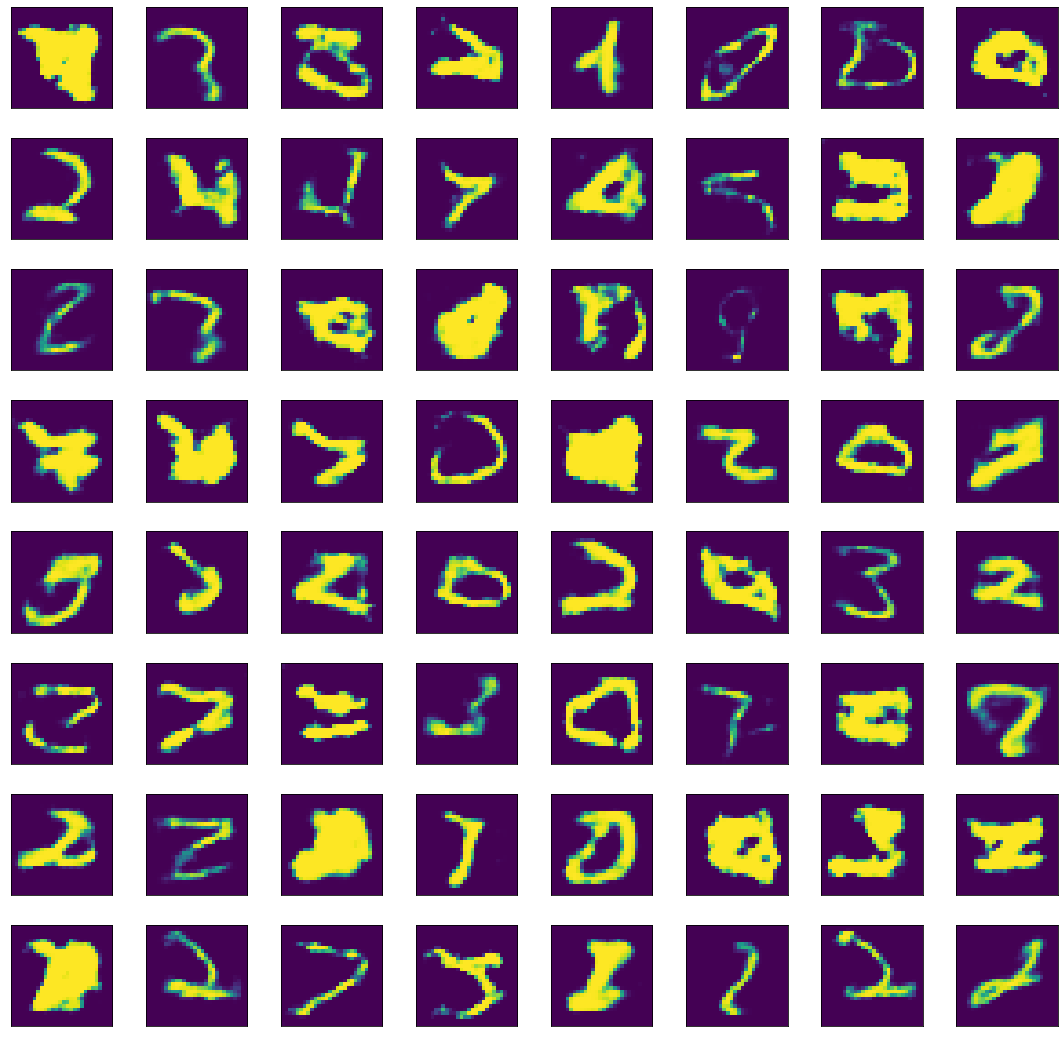

In [25]:
plot_examples(model=model, sample=True)

In [ ]:
model.eval
recon_images, mu, logvar = model(example_data.to(device),example_targets)
loss, bce, kld = loss_fn(recon_images, example_data, mu, logvar)
to_print = "Loss: {:.3f} {:.3f} {:.3f}".format(loss.data.cpu().numpy().tolist()/batch_size, bce.data.cpu().numpy().tolist()/batch_size, kld.data.cpu().numpy().tolist()/batch_size)
print(to_print)

Loss: 86.110 86.095 0.015


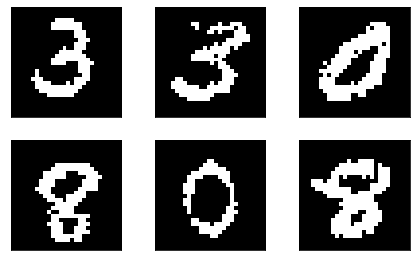

In [ ]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#     plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

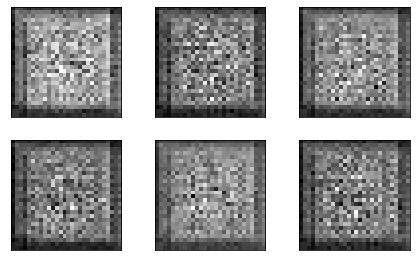

In [ ]:
example_data_nn=model(example_data.to(device),example_targets)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data_nn[0][i][0].cpu().data, cmap='gray', interpolation='none')
#     plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [ ]:
def plot_examples(model=None,sample=False,data=None):
    if data is None:
        if (model==None):
            batch_idx, (data, example_targets) = next(examples)
        else:
            batch_idx, (data, example_targets) = next(examples)
            if sample:
                zeros=torch.zeros(10,1024)
                samples= torch.cat((torch.rand(32,1024),zeros)).T
                data = model.sample(samples.to(device))
            else:
                data = model(data.to(device),example_targets)[0]
        
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.tight_layout()
        if model:
            plt.imshow(data[i][0].cpu().data, cmap='gray', interpolation='none')
        else:
            plt.imshow(data[i][0], cmap='gray', interpolation='none')
    #     plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

## Visualize outcome on training data

In [ ]:
ztest, mutest, logvartest= model.encode(example_data.to(device),example_targets)
test_data=torch.zeros(64,8)
for i in range(test_data.shape[1]):
    print('max',ztest[:,i].max())
    print('min',ztest[:,i].min())
    print('mean',ztest[:,i].mean())
    print()

max tensor(2.8716, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-1.9150, device='cuda:0', grad_fn=<MinBackward1>)
mean tensor(0.4307, device='cuda:0', grad_fn=<MeanBackward0>)

max tensor(2.3794, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-2.1294, device='cuda:0', grad_fn=<MinBackward1>)
mean tensor(-0.1143, device='cuda:0', grad_fn=<MeanBackward0>)

max tensor(1.2283, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-3.1452, device='cuda:0', grad_fn=<MinBackward1>)
mean tensor(-0.2475, device='cuda:0', grad_fn=<MeanBackward0>)

max tensor(2.6974, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-1.5885, device='cuda:0', grad_fn=<MinBackward1>)
mean tensor(0.5856, device='cuda:0', grad_fn=<MeanBackward0>)

max tensor(2.0266, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-2.4886, device='cuda:0', grad_fn=<MinBackward1>)
mean tensor(0.0975, device='cuda:0', grad_fn=<MeanBackward0>)

max tensor(3.2748, device='cuda:0', grad_fn=<MaxBackward1>)
min tensor(-1.2939

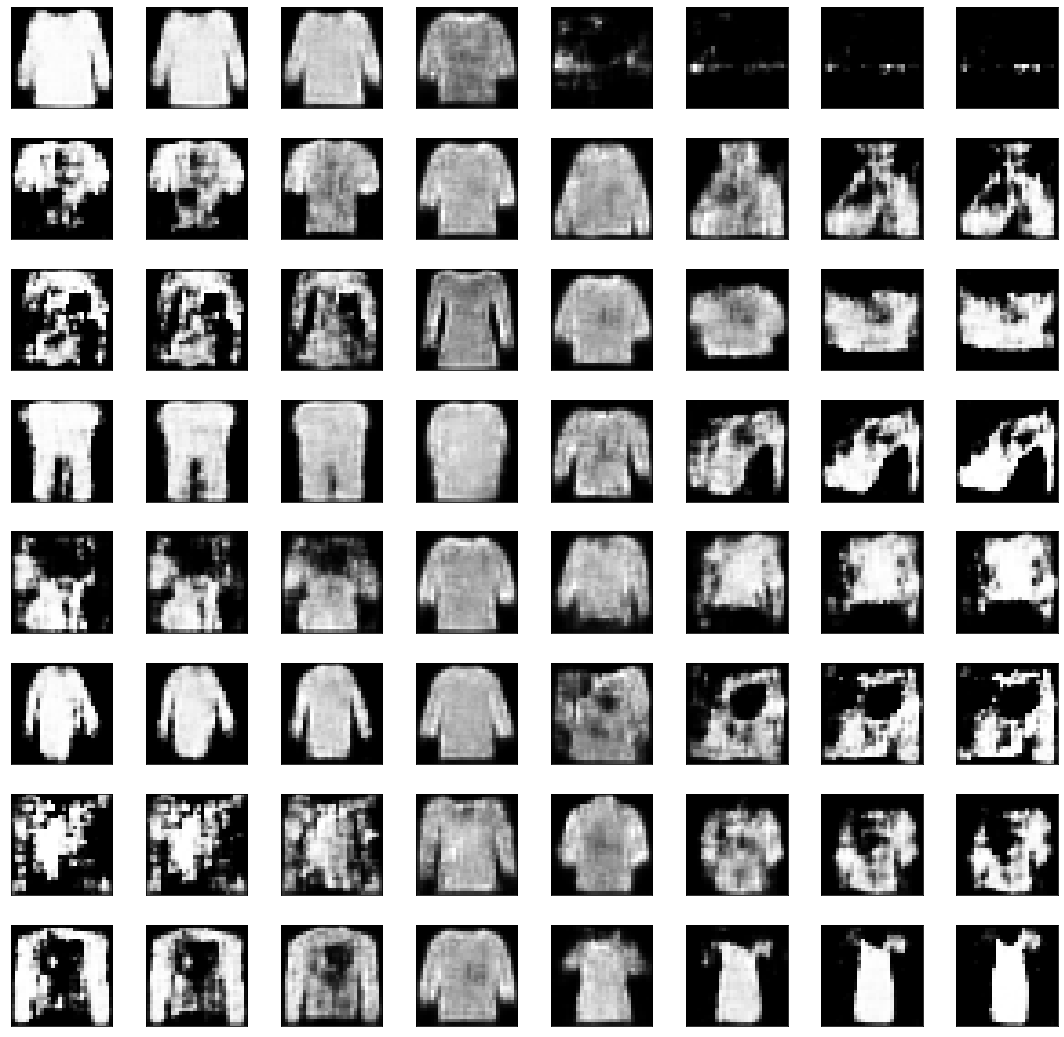

In [ ]:

for i in range(test_data.shape[0]):
    test_data[i]=ztest[0]

test_data=torch.zeros(64,8)    
range_=np.linspace(5,-5,8)
for c in range(64):
    test_data[c][int(c/8)]=range_[c%8]
smple_pic =model.sample(test_data.to(device))
plot_examples(model=True,data=smple_pic)

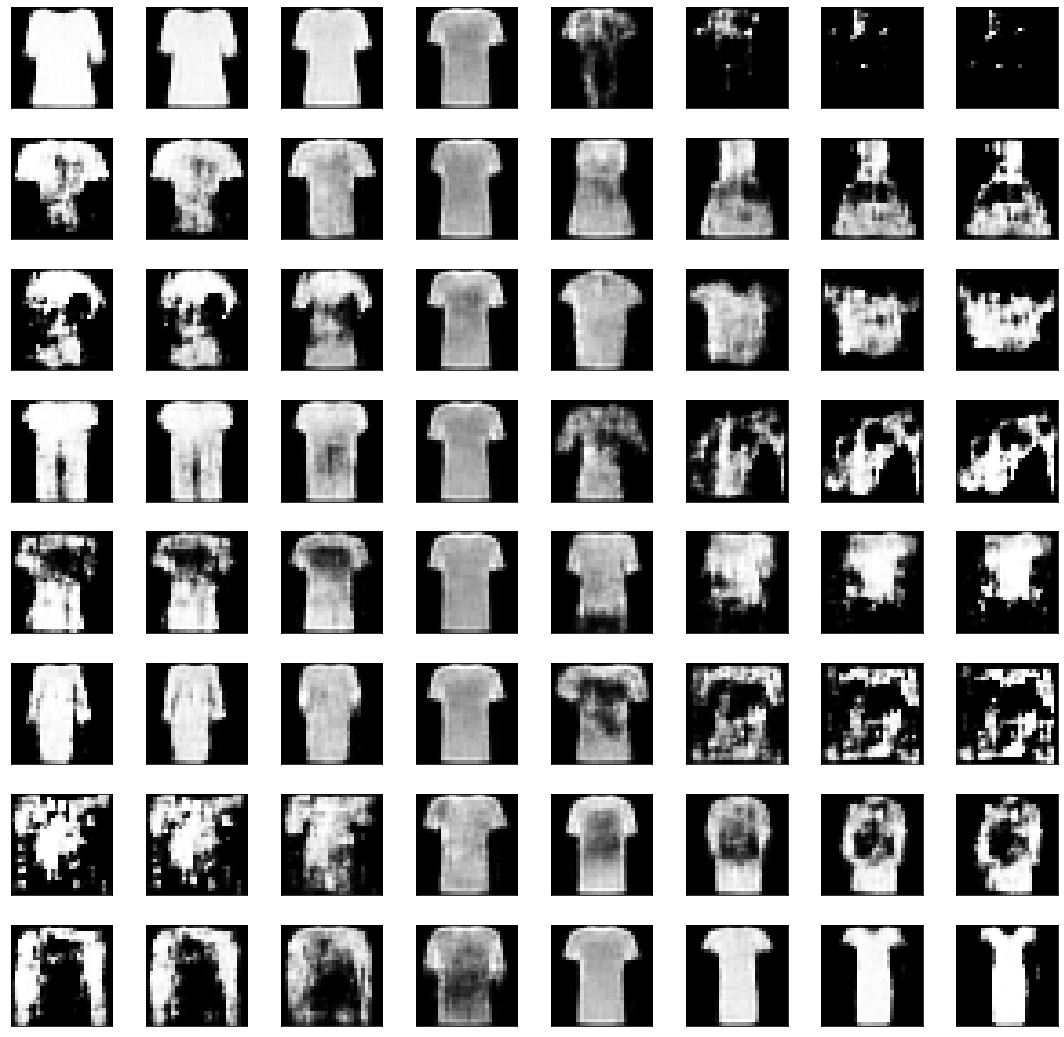

In [ ]:
test_data=torch.zeros(64,8)
for i in range(test_data.shape[0]):
    test_data[i]=ztest[1]

    
range_=np.linspace(5,-5,8)
for c in range(64):
    test_data[c][int(c/8)]=range_[c%8]
smple_pic =model.sample(test_data.to(device))
plot_examples(model=True,data=smple_pic)

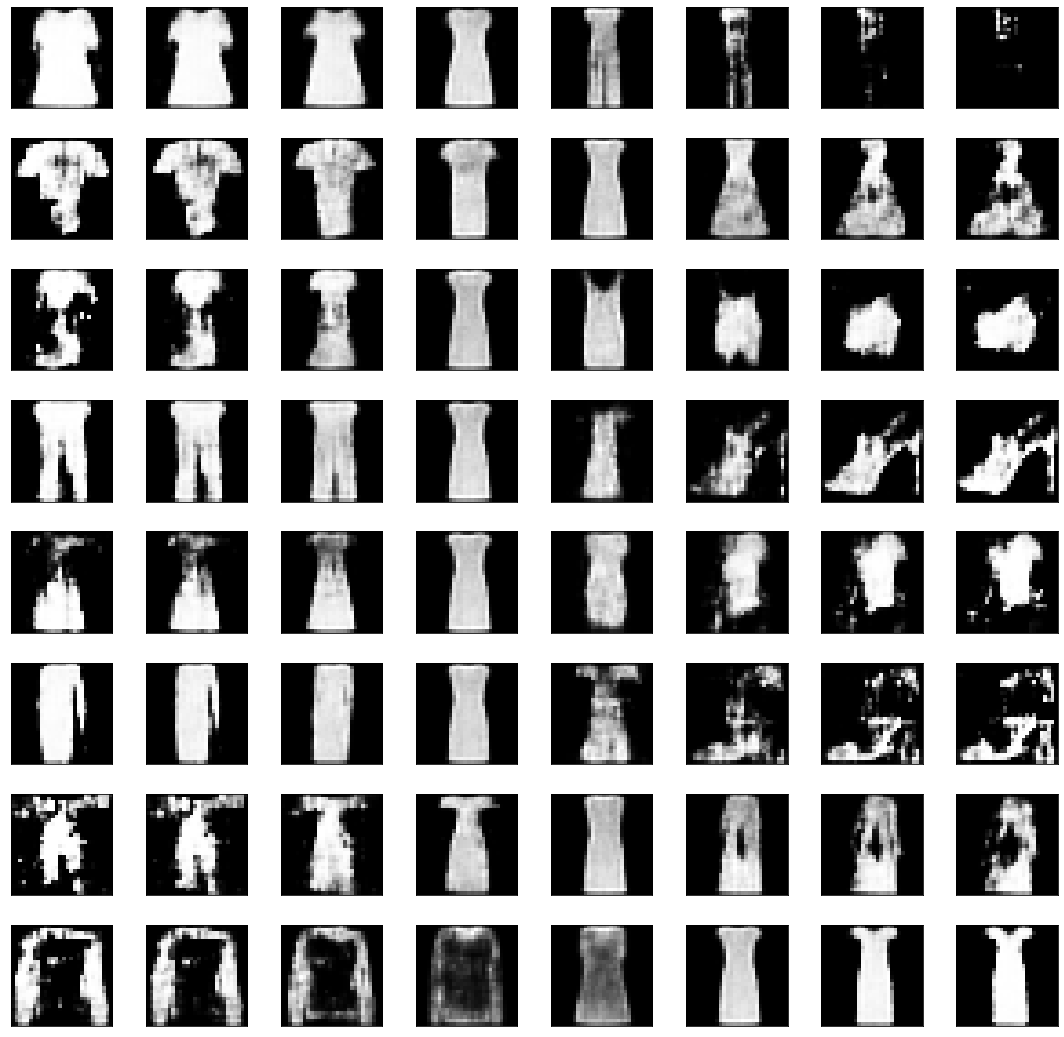

In [ ]:
test_data=torch.zeros(64,8)
for i in range(test_data.shape[0]):
    test_data[i]=ztest[2]

    
range_=np.linspace(5,-5,8)
for c in range(64):
    test_data[c][int(c/8)]=range_[c%8]
smple_pic =model.sample(test_data.to(device))
plot_examples(model=True,data=smple_pic)

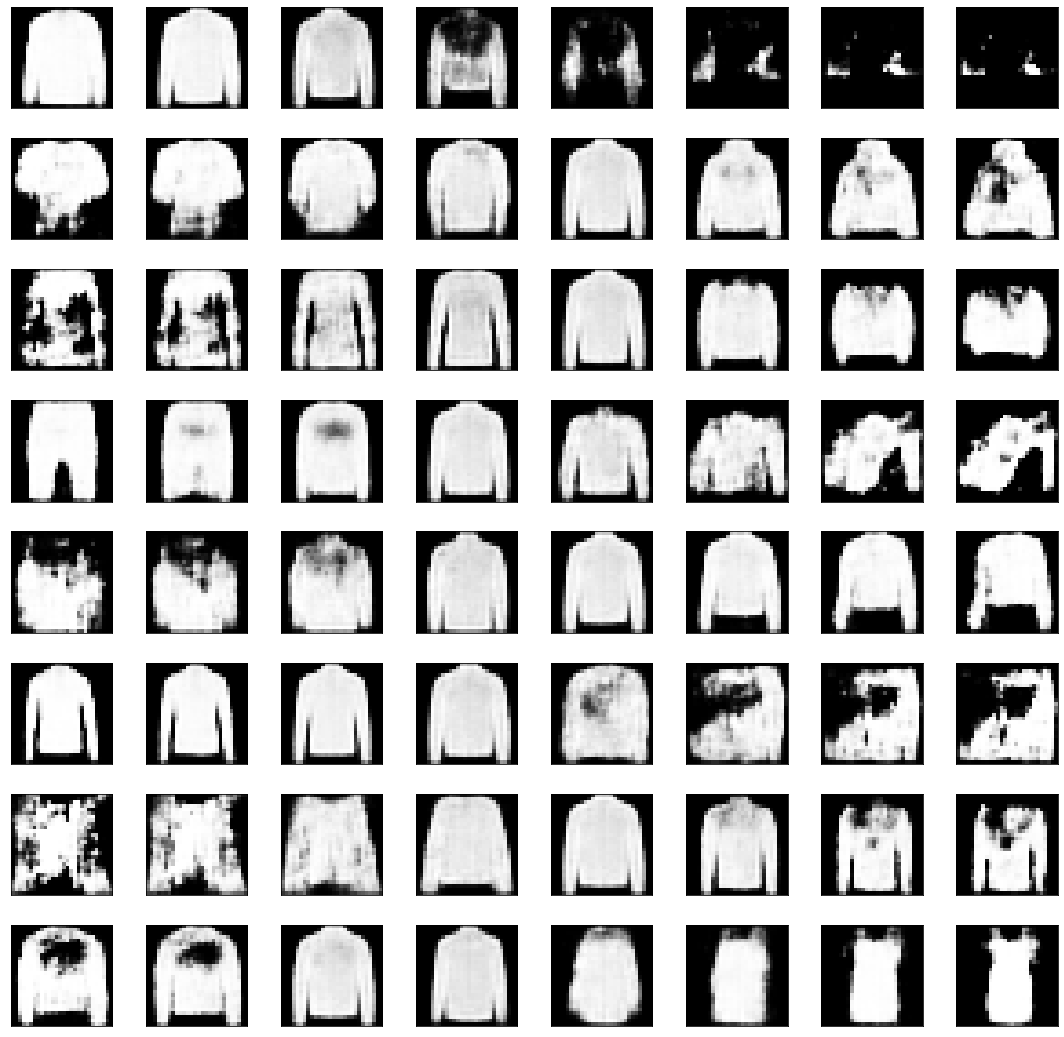

In [ ]:
test_data=torch.zeros(64,8)
for i in range(test_data.shape[0]):
    test_data[i]=ztest[3]

    
range_=np.linspace(5,-5,8)
for c in range(64):
    test_data[c][int(c/8)]=range_[c%8]
smple_pic =model.sample(test_data.to(device))
plot_examples(model=True,data=smple_pic)

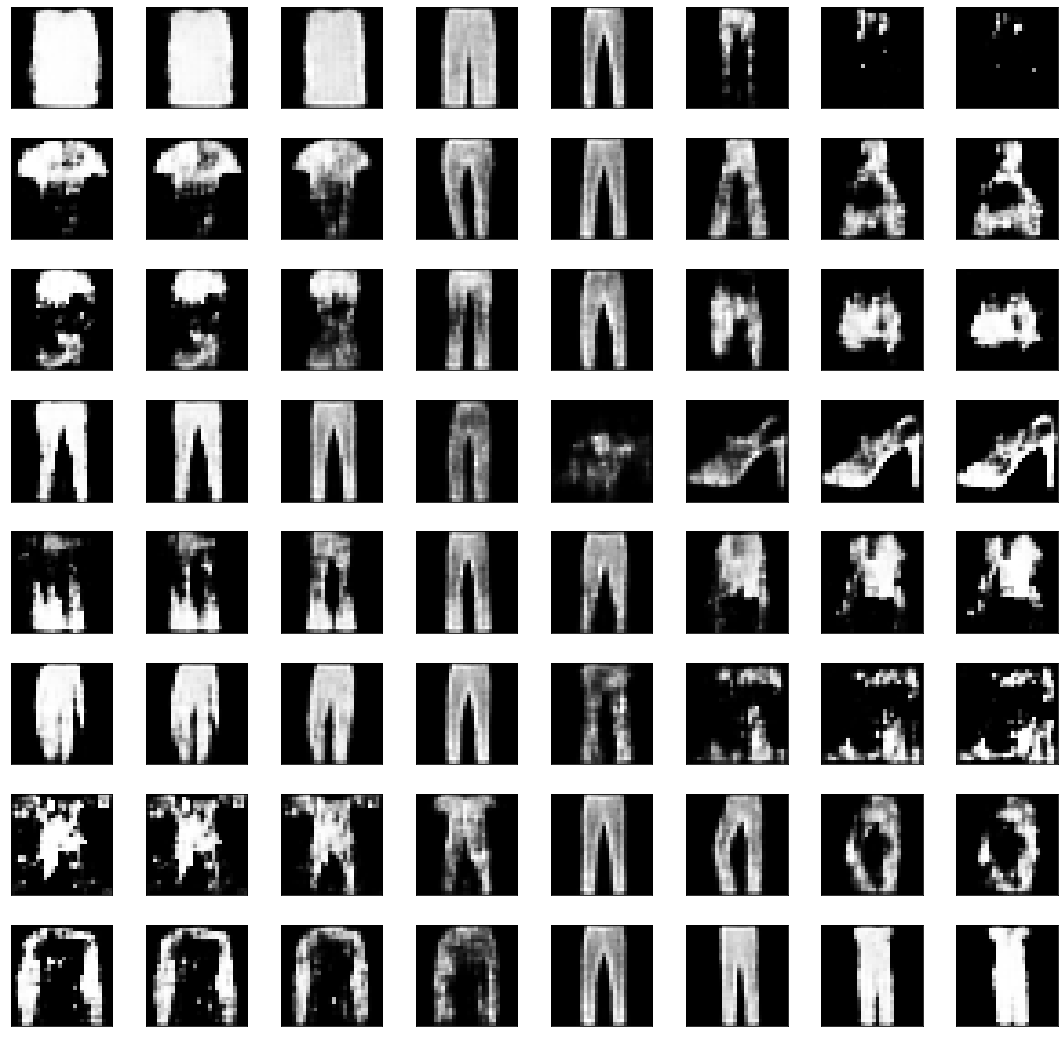

In [ ]:
test_data=torch.zeros(64,8)
for i in range(test_data.shape[0]):
    test_data[i]=ztest[4]

    
range_=np.linspace(5,-5,8)
for c in range(64):
    test_data[c][int(c/8)]=range_[c%8]
smple_pic =model.sample(test_data.to(device))
plot_examples(model=True,data=smple_pic)

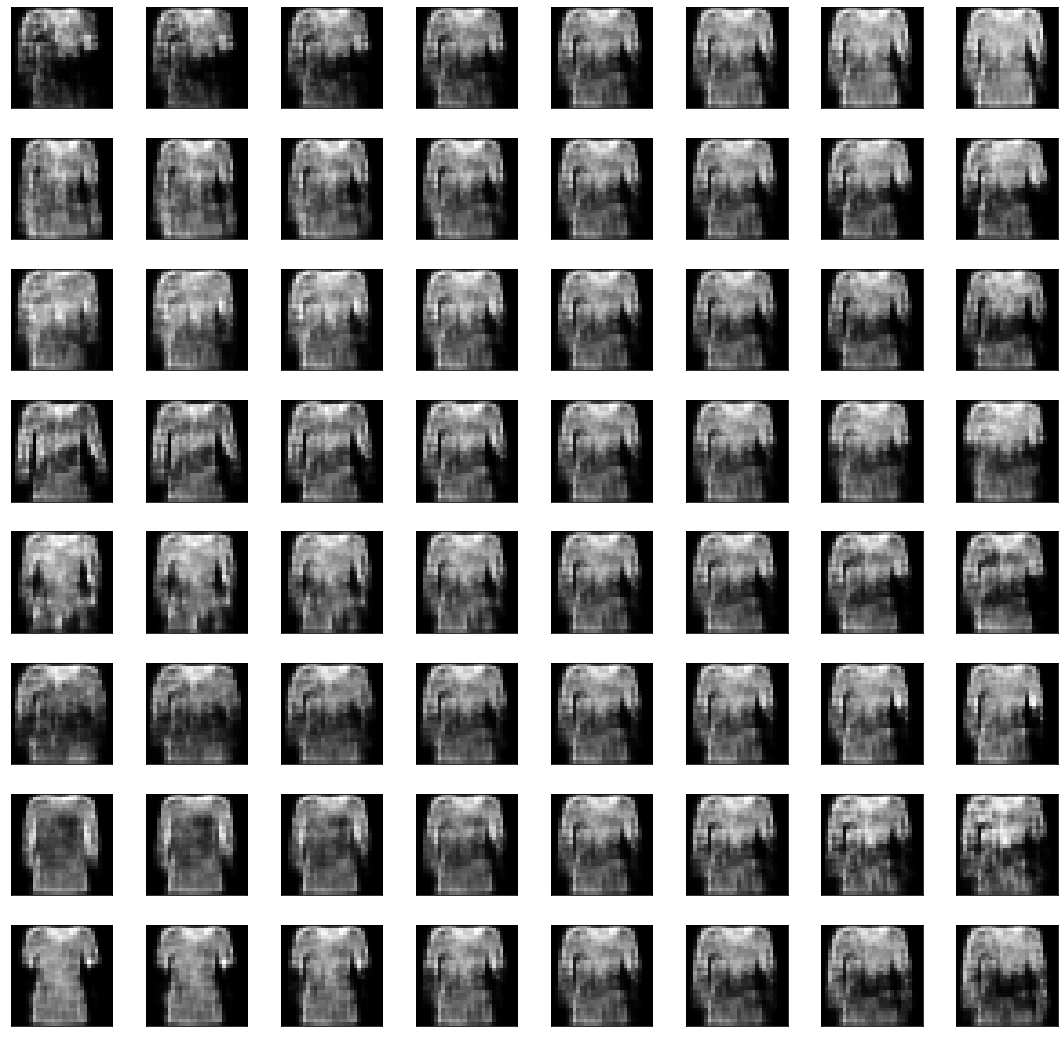

In [ ]:
zeros=torch.zeros(10,64)
c=0
for i in zeros:
    
    zeros[c,c]+=1
    c+=1
    if c==10:
        c=0
        
    
range_=np.linspace(0,1,8)
samples=(torch.ones(8,64)*0.6).T
for c in range(64):
    samples[c][int(c/8)]=range_[c%8]
smple_pic =model.sample(samples.to(device))
plot_examples(model=True,data=smple_pic)